# Икс-точка

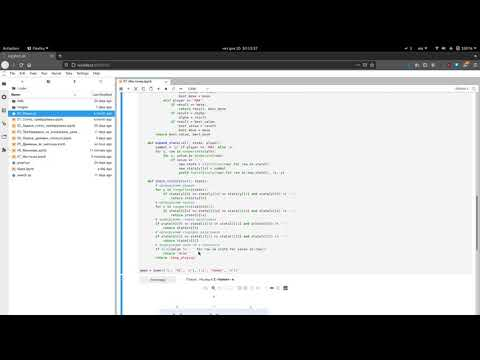

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('2tEHZEMKjHc')

In [2]:
from time import sleep
from collections import deque
from copy import deepcopy
from plotly import graph_objects as go
import ipywidgets as widgets
from IPython.display import display

In [3]:
class Game:
    def __init__(self, player_1, player_2):
        self.player_1 = {**player_1, 'symbol': 'x', 'role': 'MAX'}
        self.player_2 = {**player_2, 'symbol': 'o', 'role': 'MIN'}
        self.next_to_play = self.player_1
        self.state = [['·', '·', '·'], ['·', '·', '·'], ['·', '·', '·']]
        self.symbols_fig = {'x': 'x', 'o': 'circle', '·': 'circle-open'}
        self.scores = {'x': 1, 'o': -1, 'draw': 0}
        self.create_ui()
        hbox = widgets.HBox([self.bt_reset, self.dashboard])
        display(widgets.VBox([hbox, self.fig]))
        self.reset()

    def reset(self, *args):
        self.next_to_play = self.player_1
        self.update_score('На ред е', self.next_to_play)
        self.state = [['·', '·', '·'], ['·', '·', '·'], ['·', '·', '·']]
        self.fig.data[0].marker.symbol = self.convert_state_to_symbols()
        self.evaluated = {}
        self.winner = 'keep_playing'
        self.initiate_turn()

    def create_ui(self):
        self.dashboard = widgets.HTML(description='Статус:', value='')
        self.bt_reset = widgets.Button(description='Ресетирај')
        self.bt_reset.on_click(self.reset)
        self.fig = self.create_fig()

    def create_fig(self):
        N = 3
        fig = go.FigureWidget()
        x = [x for y in range(N) for x in range(N)]
        y = [y for y in range(N) for x in range(N)]
        symbols = [self.symbols_fig[v] for row in self.state for v in row]
        fig.add_scatter(x=x, y=y, mode='markers', marker_size=48, 
                        marker_symbol=symbols, marker_color='LightSkyBlue',
                        marker_line_width=6, marker_line_color='MediumPurple')
        fig.data[0].on_click(self.human_move)
        fig.update_xaxes(range=[-0.5, N - 0.5], dtick=1, title='x', side='top')
        fig.update_yaxes(
            range=[-0.5, N - 0.5], dtick=1, title='y', autorange='reversed')
        fig.update_layout(width=600, height=600, showlegend=False)
        return fig

    def convert_state_to_symbols(self):
        return [self.symbols_fig[v] for row in self.state for v in row]

    def initiate_turn(self):
        if 'human' not in [self.player_1['type'], self.player_2['type']]:
            while self.winner == 'keep_playing':
                self.ai_move()
        elif self.next_to_play['type'] == 'AI':
            self.ai_move()

    def ai_move(self):
        self.dashboard.value += ' -- пресметува'
        state = tuple([tuple(row) for row in self.state])
        result, move = self.minimax(state, self.next_to_play['role'])
        sleep(1)
        self.player_took_turn(*move)

    def human_move(self, trace, points, selector):
        x, y = points.xs[0], points.ys[0]
        keep_playing = self.winner == 'keep_playing'
        human_on_turn = self.next_to_play['type'] == 'human'
        empty_place = self.state[y][x] == '·'
        if keep_playing and human_on_turn and empty_place:
            self.player_took_turn(x, y)
            if self.next_to_play['type'] == 'AI':
                self.ai_move()

    def player_took_turn(self, x, y):
        self.state[y][x] = self.next_to_play['symbol']
        self.fig.data[0].marker.symbol = self.convert_state_to_symbols()
        self.winner = self.check_victory(self.state)
        if self.winner != 'keep_playing':
            if self.winner == 'draw':
                self.dashboard.value = 'Нерешено.'
            else:
                self.update_score('Победник е', self.next_to_play)
            return
        if self.next_to_play == self.player_2:
            self.next_to_play = self.player_1
        else:
            self.next_to_play = self.player_2
        self.update_score('На ред е', self.next_to_play)

    def update_score(self, message, player):
        player_data = ' - '.join(list(player.values())[:-1])
        self.dashboard.value = f'{message} <b> {player_data} </b>.'

    def minimax(self, node, player, alpha=-2, beta=2, depth=0):
        if node not in self.evaluated:
            self.evaluated[node] = self.check_victory(node)
        if self.evaluated[node] != 'keep_playing':
            return self.scores[self.evaluated[node]], None
        best_value = 2 if player == 'MIN' else -2
        best_move = None
        for child, move in self.expand_state(node, player):
            other_player = 'MIN' if player == 'MAX' else 'MAX'
            result, _ = self.minimax(child, other_player, alpha, beta, depth+1)
            if player == 'MIN':
                if result <= alpha:
                    return result, best_move
                if result < beta:
                    beta = result
                if result < best_value:
                    best_value = result
                    best_move = move
            elif player == 'MAX':
                if result >= beta:
                    return result, best_move
                if result > alpha:
                    alpha = result
                if result > best_value:
                    best_value = result
                    best_move = move
        return best_value, best_move

    def expand_state(self, state, player):
        symbol = 'x' if player == 'MAX' else 'o'
        for y, row in enumerate(state):
            for x, value in enumerate(row):
                if value == '·':
                    new_state = list([list(row) for row in state])
                    new_state[y][x] = symbol
                    yield tuple([tuple(row) for row in new_state]), (x, y)

    def check_victory(self, state):
        # проверуваме редици
        for y in range(len(state)):
            if state[y][0] == state[y][1] == state[y][2] and state[y][0] != '·':
                return state[y][0]
        # проверуваме колони
        for x in range(len(state[0])):
            if state[0][x] == state[1][x] == state[2][x] and state[0][x] != '·':
                return state[0][x]
        # проверуваме главна дијагонила
        if state[0][0] == state[1][1] == state[2][2] and state[0][0] != '·':
            return state[0][0]
        # проверуваме споредна дијагонила
        if state[0][2] == state[1][1] == state[2][0] and state[0][2] != '·':
            return state[0][2]
        # проверуваме дали сѐ е пополнето
        if all([value != '·' for row in state for value in row]):
            return 'draw'
        return 'keep_playing'


game = Game({'name': '1', 'type': 'AI'}, {'name': '2', 'type': 'human'})

## Задачи за самостојна работа

- Симулирајте ја играта [Hexapawn](https://en.wikipedia.org/wiki/Hexapawn) и видете кој е победник.
    - Оваа игра е прва задача на вториот колоквиум 2019.
    - Оваа игра има мало дрво, па можете да ја разграните играта до крај.
    - По можност, направете ја интерактивна, како што е игра икс-точка направена во оваа тетратка.
- Симулирајте ја играта [Connect4](https://en.wikipedia.org/wiki/Connect_Four) и видете кој е победник.
    - Дрвото во оваа игра е преголемо за да го истражите до крај. Затоа, напишете функција која ќе го процени резултатот на играта кога минимакс алгоритамот ќе дојде до однапред одредена длабочина.
    - По можност, направете ја интерактивна, како што е игра икс-точка направена во оваа тетратка.
    - Признак за добро сработена задача: Играта сте ја направиле доволно квалитетно ако самите не можете да ја победите.

### Решенијата во продолжение се од Васе Трендафилов

## Hexapawn

In [13]:
from plotly import graph_objects as go
import ipywidgets as widgets
from collections import deque
from copy import deepcopy
import time

In [14]:
def minimaxRoot(depth, board, player):
    global moves
    moves = board.available_moves()
    scores = {}
    bestMove = -9999 if player else 9999

    for move in moves:
        board.push(move)
        value = minimax(depth - 1, board, -10000, 10000, not player)
        scores[move] = value
        board.pop()
        #if value == 1000:
         #   bestMove = value
          #  bestMoveFound = move
           # return bestMoveFound , [],[]
        if player and value >= bestMove:
            bestMove = value
            bestMoveFound = move
        elif not player and value <= bestMove:
            bestMove = value
            bestMoveFound = move
    
    return bestMoveFound , moves,scores
def minimax(depth, board, alpha, beta, player):
    if depth == 0:
        return board.score()

    moves = board.available_moves()
   # if not moves:
    #    return 1000

    if (player):
        bestMove = -9999
        for move in moves:
            board.push(move)
            bestMove = max(bestMove, minimax(depth - 1, board, alpha, beta, not player))
            board.pop()
            alpha = max(alpha, bestMove)
            if beta <= alpha:
                return bestMove
        return bestMove
    else:
        bestMove = 9999
        for move in moves:
            board.push(move);
            bestMove = min(bestMove, minimax(depth - 1, board, alpha, beta, not player))
            board.pop()
            beta = min(beta, bestMove)
            if beta <= alpha:
                return bestMove
        return bestMove

In [15]:
class Board:
    def __init__(self, table, turn=True):
        self.table = deepcopy(table)
        self.queue = []
        self.turn = turn 
        
    def push(self,move):
        self.queue.append(move)
        self.update_table()
        self.turn = not self.turn
        
    def pop(self):
        move = self.queue.pop()
        self.update_table(move)
        self.turn = not self.turn
        return move
        
    def peek(self):
        return self.queue[-1]
    
    def update_table(self,move=None):
        if move != None:
            old, new = move
            self.table[old[0]][old[1]] = not self.turn
            self.table[new[0]][new[1]] = None if old[1]==new[1] else self.turn
        else:
            old, new = self.peek()
            self.table[old[0]][old[1]] = None
            self.table[new[0]][new[1]] = self.turn
            
    def legal_moves(self,x,y):
        x += -1 if self.turn else 1
        moves = []
        for i in range(-1,2):
            if 0 <= x < M and 0 <= y+i < N:
                if self.table[x][y+i] == None and i==0:
                    moves.append((x,y))
                elif self.table[x][y+i] == (not self.turn) and i!=0:
                    moves.append((x,y+i))
        return moves
    
    def available_moves(self):
        moves = []
        for x in range(M):
            for y in range(N):
                if self.table[x][y] == self.turn:
                    for move in self.legal_moves(x,y):
                        moves.append(((x,y),move))
        return moves
    
    def score(self):
        score = 0
        for x in range(M):
            for y in range(N):
                if self.table[x][y] != None:
                    score += M-x if self.table[x][y] == True else -(x+1)
                    if x == 0 and self.table[x][y] == True:
                        return 9999
                    elif x == M-1 and self.table[x][y] == False:
                        return -9999
        score += len([i for row in self.table for i in row if i == True]) - len([i for row in self.table for i in row if i == False])
        return score 

In [16]:
def posible_moves(x,y):
    moves = []
    if TABLE[x][y] == None:
        return moves
    for i in range(-1,2):
        if 0 <= x-1 < M and 0 <= y+i < N:
            if TABLE[x-1][y+i] == None and i==0:
                moves.append((x-1,y))
            elif TABLE[x-1][y+i] == False and i!=0:
                moves.append((x-1,y+i))
    return moves
def game_end(board):
    if False in board.table[M-1]:
        return "Red"
    elif True in board.table[0]:
        return "Blue"
    if not board.available_moves():
        return "Red" if board.turn == True else "Blue"
    return None

In [17]:
debug = True
moves = None
clicked,xf,yf= 0,0,0
def update_fig(trace, points, selector):
    x,y = points.ys[0],points.xs[0]
    global clicked, xf, yf, moves, TABLE
    clicked +=1  
    
    if clicked == 1:
        xf,yf = x,y
        temp = deepcopy(TABLE)
        moves = posible_moves(x,y)
        if not moves:  clicked = 0
            
        for i,j in moves:
            temp[i][j] = 3 if temp[i][j] == False else 2
            
        colors=['#121212' if n == None 
                else'#ff7f0e' if n == 2 else '#1f77b4' if n == 1 
                else '#d62728' if n == 0 else '#2ca02c' for row in temp for n in row]
        fig.data[0].marker['color'] = colors
        
    elif clicked == 2:
        if (x,y) in moves:
            TABLE[x][y] = True
            TABLE[xf][yf] = None
            
        colors = ['#121212' if n == None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
        fig.data[0].marker['color'] = colors
        clicked,moves = 0,None
        
        if game_end(Board(TABLE,False)) != None:
            text.value = f'<font size=4> {game_end(Board(TABLE,False))} wins !!'
            fig.data[0].on_click(None)
            return
        
        time.sleep(0.5) #AI Part
        board = Board(TABLE,False)
        move,moves,scores = minimaxRoot(4, board, False)
        if debug : 
            print([[move,scores[move]] for move in moves])
            
        board.push(move)
        TABLE = board.table
        colors = ['#121212' if n == None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
        fig.data[0].marker['color'] = colors
        
        if game_end(Board(TABLE)) != None:
            text.value = f'<font size=4> {game_end(Board(TABLE))} wins !!'
            fig.data[0].on_click(None)
            return
    
def create_fig():
    fig = go.FigureWidget()
    x = [x for y in range(M) for x in range(N)]
    y = [y for y in range(M) for x in range(N)]
    colors = ['#121212' if n == None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.add_scatter(x=x, y=y, mode='markers', marker_size=(M+1)*10+N+2, 
        marker_symbol='square', marker_color=colors,hoverinfo='none')
    fig.data[0].on_click(update_fig)
    fig.update_xaxes(range=[-0.5, N - 0.5], dtick=1, side='top', visible=False,autorange=False)
    fig.update_yaxes(range=[-0.5, M - 0.5], dtick=1, autorange='reversed', visible=False)
    fig.update_layout(width=80*N, height=80*N, showlegend=False,margin={'r':0,'l':0,'t':0,'b':0},plot_bgcolor='#212121')

    return fig

N = 4
M = 4
TABLE = [
    [False,]*N,
    [None,None,None,None],
    [None,None,None,None],
    [True,]*N,
]
fig = create_fig()
text = widgets.HTML(value='<font size=4> Hexapawn')
widgets.VBox([fig,text])

    'data': [{'hoverinfo': 'none',
              'marker': {'color': [#d62728, #…

In [6]:
debug = True
def update_fig(trace, points, selector):
    global TABLE
    
    board = Board(TABLE)
    move,moves,scores = minimaxRoot(4, board, True)
    if debug : 
        print([[move,scores[move]] for move in moves])

    board.push(move)
    TABLE = board.table
    colors = ['#121212' if n == None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.data[0].marker['color'] = colors

    if game_end(Board(TABLE)) != None:
        text.value = f'<font size=4> {game_end(Board(TABLE))} wins !!'
        fig.data[0].on_click(None)
        return 
    
    time.sleep(1) #AI Part
    board = Board(TABLE,False)
    move,moves,scores = minimaxRoot(5, board, False)
    if debug : 
        print([[move,scores[move]] for move in moves])

    board.push(move)
    TABLE = board.table
    colors = ['#121212' if n == None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.data[0].marker['color'] = colors

    if game_end(Board(TABLE)) != None:
        text.value = f'<font size=4> {game_end(Board(TABLE))} wins !!'
        fig.data[0].on_click(None)
        return
    
def create_fig():
    fig = go.FigureWidget()
    x = [x for y in range(M) for x in range(N)]
    y = [y for y in range(M) for x in range(N)]
    colors = ['#121212' if n == None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.add_scatter(x=x, y=y, mode='markers', marker_size=(M+1)*10+N+2, 
        marker_symbol='square', marker_color=colors,hoverinfo='none')
    fig.data[0].on_click(update_fig)
    fig.update_xaxes(range=[-0.5, N - 0.5], dtick=1, side='top', visible=False,autorange=False)
    fig.update_yaxes(range=[-0.5, M - 0.5], dtick=1, autorange='reversed', visible=False)
    fig.update_layout(width=80*N, height=80*N, showlegend=False,margin={'r':0,'l':0,'t':0,'b':0},plot_bgcolor='#212121')

    return fig

N = 6
M = 5
TABLE = [
    [False,]*N,
    [None,]*N,
    [None,]*N,
    [None,]*N,
    [True,]*N,
]
fig = create_fig()
text = widgets.HTML(value='<font size=4> Hexapawn')
widgets.VBox([fig,text])

    'data': [{'hoverinfo': 'none',
              'marker': {'color': [#d62728, #…

## Connect 4

In [7]:
from plotly import graph_objects as go
import ipywidgets as widgets
from collections import deque
from copy import deepcopy

In [8]:
def add_circle(y):
    for i in range(M-1,-1,-1):
        if TABLE[i][y] == None:
            break
    return i, y 
def game_end(board):
    if abs(board.x_check()) == 1000:
        return "Blue" if board.x_check() == 1000 else "Red"
    if abs(board.y_check()) == 1000:
        return "Blue" if board.y_check() == 1000 else "Red"
    if abs(board.diag_check()) == 1000:
        return "Blue" if board.diag_check() == 1000 else "Red"
    if abs(board.diag_check(False)) == 1000:
        return "Blue" if board.diag_check(False) == 1000 else "Red"
    return None

In [9]:
def minimaxRoot(depth, board, player):
    global moves
    moves = board.available_moves()
    scores = {}
    bestMove = -9999 if player else 9999

    for move in moves:
        board.push(move)
        value = minimax(depth - 1, board, -10000, 10000, not player)
        scores[move] = value
        board.pop()
        if player and value >= bestMove:
            bestMove = value
            bestMoveFound = move
        elif not player and value <= bestMove:
            bestMove = value
            bestMoveFound = move
    
    return bestMoveFound , moves,scores
def minimax(depth, board, alpha, beta, player):
    if depth == 0:
        return board.score()

    moves = board.available_moves()

    if (player):
        bestMove = -9999
        for move in moves:
            board.push(move)
            bestMove = max(bestMove, minimax(depth - 1, board, alpha, beta, not player))
            board.pop()
            alpha = max(alpha, bestMove)
            if beta <= alpha:
                return bestMove
        return bestMove
    else:
        bestMove = 9999
        for move in moves:
            board.push(move);
            bestMove = min(bestMove, minimax(depth - 1, board, alpha, beta, not player))
            board.pop()
            beta = min(beta, bestMove)
            if beta <= alpha:
                return bestMove
        return bestMove

In [10]:
class Board:
    def __init__(self, table, turn):
        self.table = deepcopy(table)
        self.queue = []
        self.turn = turn 
        
    def push(self,move):
        self.queue.append(move)
        self.update_table()
        self.turn = not self.turn
        
    def pop(self):
        move = self.queue.pop()
        self.update_table(move)
        self.turn = not self.turn
        return move
        
    def peek(self):
        return self.queue[-1]
    
    def update_table(self,move=None):
        if move != None:
            for x in range(M-1,-1,-1):
                if self.table[x][move] == None:
                    break
            if self.table[x][move] != None:
                self.table[x][move] = None
            else:
                self.table[x+1][move] = None
        else:
            y = self.peek()
            for x in range(M-1,-1,-1):
                if self.table[x][y] == None:
                    break
            self.table[x][y] = self.turn
        
    def available_moves(self):
        moves = []
        for y in range(N):
            if self.table[0][y] == None:
                moves.append(y)
        return moves
    
    def score(self):
        score = 0
        score += self.x_check()
        score += self.y_check()
        score += self.diag_check()
        score += self.diag_check(False)
        return score
   

    def x_check(self):
        score = 0
        prices = [10,20,40,1000]
        blue, red, blue_start, red_start= -1,-1,-1,-1
        for x in range(M):
            left = 1+len([y for y in range(N) if self.table[x][y] == None])
            for y in range(N):
                if red == 3:
                    return -1000
                if blue == 3:
                    return 1000
                if self.table[x][y] == True:# blue to red transition
                    blue += 1
                    if blue == 0:
                        blue_start = y 
                    if red >= 0:
                        score -= 0 if self.table[x][red_start-1] == True or red_start == 0 else prices[red]/(2*left)
                        red, red_start = -1, -1
                        
                elif self.table[x][y] == False:# red to blue transition
                    red += 1
                    if red == 0:
                        red_start = y 
                    if blue >= 0:
                        score += 0 if self.table[x][blue_start-1] == False or blue_start == 0 else prices[blue]/(2*left)
                        blue, blue_start = -1, -1
                elif self.table[x][y] == None:# to none transition
                    if blue >= 0:
                        score += prices[blue]/(2*left) if self.table[x][blue_start-1] == False or blue_start == 0 else prices[blue]/left        
                    if red >= 0:
                        score -= prices[red]/(2*left) if self.table[x][red_start-1] == True or red_start == 0 else prices[red]/left
                    blue, red, blue_start, red_start= -1,-1,-1,-1
            
            if blue >= 0:# most top case
                score += 0 if self.table[blue_start-1][y] == False else prices[blue]/(2*left) 
            if red >= 0:
                score -= 0 if self.table[red_start-1][y] == True  else prices[red]/(2*left) 
            blue, red, blue_start, red_start= -1,-1,-1,-1
        return score
    
    def y_check(self):
        score = 0
        prices = [4,9,19,1000]
        blue, red, blue_start, red_start= -1,-1,-1,-1
        for y in range(N):
            left = 1#+len([x for x in range(M) if self.table[x][y] == None])
            for x in range(M-1,-1,-1):
                
                if red == 3:
                    return -1000
                if blue == 3:
                    return 1000
                
                if self.table[x][y] == True:
                    blue += 1
                    if blue == 0:
                        blue_start = x 
                    if red >= 0:
                        red, red_start = -1, -1
                        
                elif self.table[x][y] == False:
                    red += 1
                    if red == 0:
                        red_start = x 
                    if blue >= 0:
                        blue, blue_start = -1, -1
                elif self.table[x][y] == None:
                    if blue >= 0:
                        score += prices[blue]/left
                    if red >= 0:
                        score -= prices[red]/left
                    blue, red, blue_start, red_start= -1,-1,-1,-1
                    
            blue, red, blue_start, red_start= -1,-1,-1,-1
        return score
       
    def diag_check(self,main=True):
        score = 0
        blue, red= -1,-1
        row,col,x,y = 0,0,0,0
        table = self.table[::-1] if main else self.table
        
        while row+1!= M or col!= N:
            
            if table[x][y] == True:
                blue += 1
                if red >= 0: red = -1
            elif table[x][y] == False:
                red += 1
                if blue >= 0:blue = -1
            elif table[x][y] == None:
                blue, red= -1,-1
                
            if red == 3:
                return -1000
            if blue == 3:
                return 1000
            
            x-=1
            y+=1
            if x<0 and row+1 == M:
                col+=1
                x=row
                y=col
                blue, red= -1,-1
            elif x<0 and row+1< M:
                row+=1
                x=row
                y=col
                blue, red= -1,-1
            elif y>N-1:
                col+=1
                y=col
                x=row
                blue, red= -1,-1
        return score

In [12]:
turn = True
debug = True
def update_fig(trace, points, selector):
    x, y = add_circle(points.xs[0])
    global turn
    TABLE[x][y] = turn
    turn = not turn
    
    board = Board(TABLE,False)
    y, moves,scores = minimaxRoot(4, board, False)
    if debug : 
        print([(move,scores[move]) for move in moves])
    x,y = add_circle(y)
    TABLE[x][y] = turn
    turn = not turn
    colors = ['#121212' if n == None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.data[0].marker['color'] = colors
    
    if game_end(Board(TABLE,True)) != None:
        text.value = f'<font size=4> {game_end(Board(TABLE,True))} wins !!'
        fig.data[0].on_click(None)


def create_fig():
    fig = go.FigureWidget()
    x = [x for y in range(M) for x in range(N)]
    y = [y for y in range(M) for x in range(N)]
    colors = ['#121212' if n == None else '#1f77b4' if n else '#d62728' for row in TABLE for n in row]
    fig.add_scatter(x=x, y=y, mode='markers', marker_size=48, 
        marker_symbol='circle', marker_color=colors,hoverinfo='none')
    fig.data[0].on_click(update_fig)
    fig.update_xaxes(range=[-0.5, N - 0.5], dtick=1, side='top', visible=False,autorange=False)
    fig.update_yaxes(range=[-0.5, M - 0.5], dtick=1, autorange='reversed', visible=False)
    fig.update_layout(width=80*N, height=80*N, showlegend=False,margin={'r':0,'l':0,'t':0,'b':0},plot_bgcolor='#212121')

    return fig

N = 7
M = 6
TABLE = [
    [None, None, None, None, None, None, None],
    [None, None, None, None, None, None, None],
    [None, None, None, None, None, None, None],
    [None, None, None, None, None, None, None],
    [None, None, None, None, None, None, None],
    [None, None, None, None, None, None, None],
]
fig = create_fig()
text = widgets.HTML(value='<font size=4> Connect 4')
widgets.VBox([fig,text])

    'data': [{'hoverinfo': 'none',
              'marker': {'color': [#121212, #…